# Train P-Net 2
- 10000 train images, 1000 eval images
- EPOCH = 40
- LR = 0.001
- batch size = 32
- num of worker = 8
- loss configuration: 1.0 for label, 0.5 for offset

#### credit
Many key functions in this notebook are adopted from the following two github repositories：<br>
*https://github.com/TropComplique/mtcnn-pytorch*<br>
*https://github.com/GitHberChen/MTCNN_Pytorch*

In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
from PIL import Image
import os.path as osp
import numpy as np
from numpy.random import uniform
import PIL
from PIL import Image, ImageDraw
from random import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import random
import argparse
import os
import copy
import json
import warnings
warnings.filterwarnings("ignore")

## customized dataset
### get widerface data

In [3]:
root =  '/kaggle/input/wider-data'
setdic = {'train':(12876,'WIDER/WIDER_train'),
           'val':(3226,'WIDER/WIDER_val'), 
           'test': (16097,'WIDER/WIDER_test')}

def get_widerdata(phase, num_images, Random=True):
    
    def is_valid_image(path):
        try:
            i = Image.open(path)
            valid = True
        except:
            print('image open failure +1')
            valid = False
        return valid
    
    file = open('/kaggle/input/-mytxt/'+ phase +'.txt')
    result = []
    gts = []
    if Random:
        indexes = random.sample(range(0, setdic[phase][0]), num_images)
    else:
        indexes = [i for i in range(num_images)]
        
    lines = file.readlines()
    c=-1
    for line in lines:
        c +=1
        if c not in indexes:
            continue
        line = line.strip()
        idx = line.find('|')
        name = line[:idx]
        faces = line[idx+1:].split(',')
        image_full_path = os.path.join(root,setdic[phase][1],name)

        if is_valid_image(image_full_path):
            boxes2D = []
            for b in faces:
                b = b.split()[:4]
                boxes2D.append([int(i) for i in b])
            result.append([image_full_path, boxes2D])
            
    return result

### get landmark data (not used)

In [4]:
def get_landmarkdata(txt_path, img_dir):

    if txt_path is None or img_dir is None:
        return []
    if osp.exists(txt_path):
        img_faces = []
        with open(txt_path, 'r') as f:
            l = []
            lines = list(map(lambda line: line.strip().split('\n'), f))
            lines = [i[0].split(' ') for i in lines]
            
            for line in lines:
                img_path = line[0].replace('\\', '/')
                faces_pos = [int(i) for i in line[1:5]]
                landmark = [float(i) for i in line[5:]]
                real_img_path = osp.join(img_dir, img_path)
                if osp.exists(real_img_path):
                    try:
                        Image.open(real_img_path).verify()
                        print(real_img_path)
                        img_faces.append([real_img_path, faces_pos, landmark])
                    except:
                        continue
                else:
                    continue

        return img_faces
    else:
        print('This txt file not exist!')

### PnetDataset: gives both boxes and landmarks 
(landmark not used this time)

In [6]:
class PnetDataset(data.Dataset):
    def __init__(self, img_face_landmark, img_faces, cropsize, ratio=(2, 1, 1, 1)):

        self.img_faces = img_face_landmark + img_faces
        shuffle(self.img_faces)
        self.crop_size = cropsize
        ratio_sum = float(sum(ratio))
        self.ratio = [i / ratio_sum for i in ratio]
        self.cache = []

    def get_img_faces_ldmk(self, index):
        def load_img(img_path):
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
            except Exception:
                return
            return img

        img_face = self.img_faces[index]
        img_path = img_face[0]
        faces = np.array(img_face[1])
        
        if faces.ndim is 1:
            try:
                faces = np.expand_dims(faces, 0)
                faces[:, :] = faces[:, (0, 2, 1, 3)]
            except:
                print('error:',img_path)
        else:
            faces[:, 2] += faces[:, 0]
            faces[:, 3] += faces[:, 1]
        ldmk = None if len(img_face) < 3 else [int(i) for i in img_face[2]]

        return load_img(img_path), faces, ldmk

    
    def get_crop_img_label_offset_ldmk(self, img, faces, ldmk, index):
        def get_crop_img(img_np, crop_box, crop_size):
            crop_box = [int(i) for i in crop_box]
            crop_img_np = img_np[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :]
            crop_img = Image.fromarray(crop_img_np, mode='RGB')
            crop_img = crop_img.resize((crop_size, crop_size), resample=PIL.Image.BILINEAR)
            return crop_img

        def get_real_label(label):
            return {'n': 'n', 'np': 'n', 'pf': 'pf' if ldmk is None else 'l',
                    'p': 'p' if ldmk is None else 'l'}.get(label)

        def cal_offset(face, box):
            if box is None:
                return []
            offset = [
                (face[0] - box[0]) / float(box[2] - box[0]),
                (face[1] - box[1]) / float(box[3] - box[1]),
                (face[2] - box[2]) / float(box[2] - box[0]),
                (face[3] - box[3]) / float(box[3] - box[1]),
            ]
            return offset

        def cal_landmark_offset(box, ldmk):
            if ldmk is None or box is None:
                return []
            else:
                minx, miny = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                ldmk_offset = [(ldmk[i] - [minx, miny][i % 2]) / float([w, h][i % 2]) for i in range(len(ldmk))]
                return ldmk_offset

        img_np = np.array(img)
        width, height = img.size
        
        
        # negative, negative partial, partial face, positive
        label = np.random.choice(['n', 'np', 'pf', 'p'], p=self.ratio)
        iou_th = {'n': (0, 0.3), 'np': (0, 0.3), 'pf': (0.4, 0.65), 'p': (0.65, 1.0)}.get(label)
        sigma = {'n': 1, 'np': 0.3, 'pf': 0.1, 'p': 0.02}.get(label)
        face, face_max_size = None, None
        for i in range(10):
            face = faces[np.random.randint(len(faces))]
            face_max_size = max(face[2] - face[0], face[3] - face[1])
            if face_max_size > self.crop_size:
                break
                
        crop_img = None
        crop_box = None
        
        for i in range(10):
            max_size = min(width, height)
            size = (uniform(-1.0, 1.0) * sigma + 1) * face_max_size
            size = min(max(self.crop_size, size), max_size)
            x1, y1 = face[0], face[1]
            crop_x1, crop_y1 = (uniform(-1.0, 1.0) * sigma + 1) * x1, (uniform(-1.0, 1.0) * sigma + 1) * y1
            crop_x1, crop_y1 = min(max(0, crop_x1), width - size), min(max(0, crop_y1), height - size)
            crop_box = np.array([int(crop_x1), int(crop_y1), int(crop_x1 + size), int(crop_y1 + size)])
            iou = IoU(crop_box, np.array([face]))
            iou_max_idx = iou.argmax()
            iou = iou.max()
            if iou < iou_th[0] or iou > iou_th[1]:
                continue
            else:
                crop_img = get_crop_img(img_np, crop_box, self.crop_size)
                break
        return crop_img, get_real_label(label), cal_offset(face, crop_box), cal_landmark_offset(crop_box, ldmk)
    
    
    def __getitem__(self, index):
        img, faces, ldmk = self.get_img_faces_ldmk(index)
        crop_img, label, offset, ldmk = self.get_crop_img_label_offset_ldmk(img, faces, ldmk, index)
        if crop_img is None: return self.__getitem__(np.random.randint(0, self.__len__()))
        img_tensor = transforms.ToTensor()(crop_img)
        landmark_flag = torch.FloatTensor([1.0 if label == 'l' else 0.0])
        label = torch.FloatTensor([1.0 if label in ['p', 'pf', 'l'] else 0.0])
        offset = torch.FloatTensor(offset if 4 == len(offset) else 4 * [0.0])
        landmark = torch.FloatTensor(ldmk if 10 == len(ldmk) else 10 * [0.0])
        return (img_tensor, label, offset, landmark_flag, landmark)

    def __len__(self):
        return len(self.img_faces)

## P-Net and customized loss function

In [7]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)
        

class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(10, 16, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.PReLU()
        )
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1,)
        self.apply(weights_init)

        
    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        landmark = self.conv4_3(x)
        return det, box, landmark

In [8]:
class LossFn:
    def __init__(self, cls_factor=1, box_factor=1, landmark_factor=1):

        self.cls_factor = cls_factor
        self.box_factor = box_factor
        self.land_factor = landmark_factor
        self.loss_cls = nn.BCELoss()
        self.loss_box = nn.MSELoss()
        self.loss_landmark = nn.MSELoss()


    def cls_loss(self, gt_label, pred_label):
        
        pred_label = torch.squeeze(pred_label)
        gt_label = torch.squeeze(gt_label)
        mask = torch.ge(gt_label, 0)        
        valid_gt_label = gt_label[mask]
        valid_pred_label = pred_label[mask]
        
        return self.loss_cls(valid_pred_label, valid_gt_label) * self.cls_factor
    
    
    def box_loss(self, gt_label, gt_offset, pred_offset):

        pred_offset = torch.squeeze(pred_offset)
        gt_offset = torch.squeeze(gt_offset)
        gt_label = torch.squeeze(gt_label)
        mask = torch.eq(gt_label, 1)
        
        valid_gt_offset = gt_offset[mask, :]
        valid_pred_offset = pred_offset[mask, :]
        valid_sample_num = valid_gt_offset.shape[0]
        
        if 0 == valid_sample_num:
            return torch.tensor([0.0])
        else:
            return self.loss_box(valid_pred_offset, valid_gt_offset) * self.box_factor

        
    def landmark_loss(self, landmark_flag, gt_landmark=None, pred_landmark=None):

        pred_landmark = torch.squeeze(pred_landmark)
        gt_landmark = torch.squeeze(gt_landmark)
        gt_label = torch.squeeze(landmark_flag)
        mask = torch.eq(gt_label, 1)
        valid_gt_landmark = gt_landmark[mask, :]
        valid_pred_landmark = pred_landmark[mask, :]
        valid_sample_num = valid_gt_landmark.shape[0]
        
        if 0 == valid_sample_num:
            return torch.tensor([0.0])
        else:
            return self.loss_landmark(valid_pred_landmark, valid_gt_landmark) * self.land_factor

        
    def total_loss(self, gt_label, pred_label, gt_offset, pred_offset, landmark_flag, gt_landmark, pred_landmark):
        return self.cls_loss(gt_label, pred_label) \
               + self.box_loss(gt_label, gt_offset, pred_offset) \
               + self.landmark_loss(landmark_flag, gt_landmark, pred_landmark)

In [9]:
def IoU(box, boxes):
    
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)

    xx1 = np.maximum(box[0], boxes[:, 0])
    yy1 = np.maximum(box[1], boxes[:, 1])
    xx2 = np.minimum(box[2], boxes[:, 2])
    yy2 = np.minimum(box[3], boxes[:, 3])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    inter = w * h
    ovr = inter / (box_area + area - inter)
    return ovr

In [11]:
def visualize_accuracy(statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch')
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch')
        ax2.legend();
    fig.show()
    fig.savefig(fig_name)

In [12]:
def train_Pnet(model, criterion, optimizer, loss_config, scheduler=None):
    
    train_begin = time.time()
    min_loss = 100.0
    best_model_wts = copy.deepcopy(model.state_dict())
    statistics = {'train':([],[]), 'eval':([],[])} # 'train':([loss],[acc])   

    for epoch in range(EPOCH):
        print('Epoch {}/{}'.format(epoch, EPOCH - 1))
        print('-' * 10)
        
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        
        for (img_tensor, label, offset, landmark_flag, landmark) in P_trainLoader:
            
            wrap = (img_tensor, label, offset, landmark)
            (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
            det, box, ldmk = model(img_tensor)
            if landmark==None:
                ldmk=None
            optimizer.zero_grad()
            all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                       landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)

            all_loss.backward()
            optimizer.step()
            
            running_loss += all_loss.item() * img_tensor.size(0)
            
        epoch_loss = running_loss / P_trainSize
        statistics['train'][0].append(epoch_loss)
        print('Train Loss: {:.4f} Acc: NA'.format(epoch_loss))
        
        
        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_acc = 0.0

            for (img_tensor, label, offset, landmark_flag, landmark) in P_evalLoader:

                wrap = (img_tensor, label, offset, landmark)
                (img_tensor, label, offset, landmark) = [i.cuda() for i in wrap]
                det, box, ldmk = model(img_tensor)
                if landmark==None:
                    ldmk=None
                all_loss = criterion.total_loss(gt_label=label, pred_label=det, gt_offset=offset, pred_offset=box,
                                           landmark_flag=landmark_flag, pred_landmark=ldmk, gt_landmark=landmark)

                running_loss += all_loss.item() * img_tensor.size(0)

            epoch_loss = running_loss / P_evalSize
            statistics['eval'][0].append(epoch_loss)
            print('Eval Loss: {:.4f} Acc: NA'.format(epoch_loss))
        print()
        
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    train_length = time.time() - train_begin
    print('Training complete in {:.0f}m {:.0f}s'.format(train_length // 60, train_length % 60))
    print('Min train loss: {:4f}'.format(min_loss))
    model.load_state_dict(best_model_wts)
    
    return model, statistics

## parameter assignment and start training

In [13]:
global DEVICE
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

    
landmark_data_dir = None      # dir of CelebA image file
landmark_data_txt_path = None # path of CelebA .txt file
LR = 0.001
EPOCH = 40
BATCH_SIZE = 32
NUM_WORKS = 8
Pnet_loss_config = [1.0, 0.5, 0.5]

# train: 10000 images
widerdata_train = get_widerdata('train', 10000)
landmark_train = get_landmarkdata(landmark_data_txt_path, landmark_data_dir)

P_trainset = InplaceDataset(landmark_train, widerdata_train, cropsize=12)
P_trainLoader = DataLoader(P_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

# eval: 1000 images
widerdata_eval = get_widerdata('val', 1000)
landmark_eval = get_landmarkdata(landmark_data_txt_path, landmark_data_dir)

P_evalset = InplaceDataset(landmark_eval, widerdata_eval, cropsize=12)
P_evalLoader = DataLoader(P_evalset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKS, pin_memory=False)

P_trainSize = len(P_trainset)
P_evalSize = len(P_evalset)
print(P_trainSize)
print(P_evalSize)

model = P_Net().cuda()
model.load_state_dict(torch.load('/kaggle/input/trainedmtcnn/Pnet1.pth'))

# since landmark is not used in this project, the conv specificly producing the landmarks
# are not expected to be updated and influential to training and calculating loss
for param in model.conv4_3.parameters():
    param.requires_grad = False
    
optimizer = opt.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = LossFn(cls_factor=Pnet_loss_config[0], box_factor=Pnet_loss_config[1], landmark_factor=Pnet_loss_config[2])

image open failure +1
image open failure +1
image open failure +1
9997
1000


In [14]:
model, statistics = train_Pnet(model, criterion, optimizer, Pnet_loss_config, scheduler=None)

Epoch 0/39
----------
Train Loss: 0.3612 Acc: NA
Eval Loss: 0.4066 Acc: NA

Epoch 1/39
----------
Train Loss: 0.3494 Acc: NA
Eval Loss: 0.3983 Acc: NA

Epoch 2/39
----------
Train Loss: 0.3487 Acc: NA
Eval Loss: 0.3548 Acc: NA

Epoch 3/39
----------
Train Loss: 0.3383 Acc: NA
Eval Loss: 0.3329 Acc: NA

Epoch 4/39
----------
Train Loss: 0.3290 Acc: NA
Eval Loss: 0.3584 Acc: NA

Epoch 5/39
----------
Train Loss: 0.3373 Acc: NA
Eval Loss: 0.3430 Acc: NA

Epoch 6/39
----------
Train Loss: 0.3274 Acc: NA
Eval Loss: 0.3444 Acc: NA

Epoch 7/39
----------
Train Loss: 0.3200 Acc: NA
Eval Loss: 0.3431 Acc: NA

Epoch 8/39
----------
Train Loss: 0.3117 Acc: NA
Eval Loss: 0.3482 Acc: NA

Epoch 9/39
----------
Train Loss: 0.3179 Acc: NA
Eval Loss: 0.3421 Acc: NA

Epoch 10/39
----------
Train Loss: 0.3228 Acc: NA
Eval Loss: 0.3642 Acc: NA

Epoch 11/39
----------
Train Loss: 0.3139 Acc: NA
Eval Loss: 0.3659 Acc: NA

Epoch 12/39
----------
Train Loss: 0.3090 Acc: NA
Eval Loss: 0.3103 Acc: NA

Epoch 13/

### store model and data

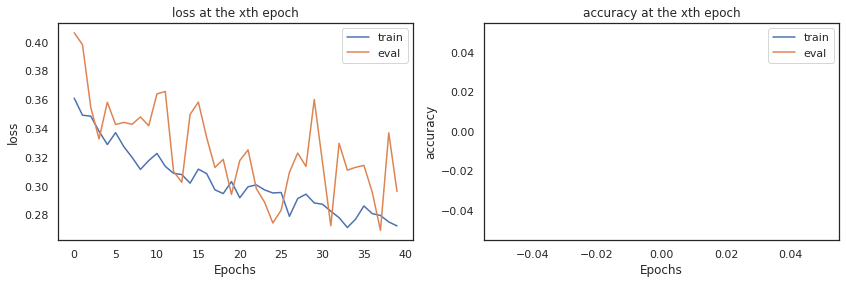

In [15]:
name = 'PNet2'
torch.save(model.state_dict(), '/kaggle/working/'+name+'.pth')
json.dump(statistics, open(name+'.json', 'w'))
visualize_accuracy(statistics, name)

## Demo of performance
choose several fixed images in train/val and visualize their predicted boxes

In [16]:
def run_first_stage(image, net, scale, threshold):

    width, height = image.size
    sw, sh = math.ceil(width * scale), math.ceil(height * scale)
    img = image.resize((sw, sh), Image.BILINEAR)

    img = transforms.ToTensor()(img).unsqueeze(0)
    img = img.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    output = net(img)
    probs = output[0].data.cpu().numpy()[0, 0, :, :]
    offsets = output[1].data.cpu().numpy()
    boxes = _generate_bboxes(probs, offsets, scale, threshold)
    if len(boxes) == 0:
        return None

    keep = nms(boxes[:, 0:5], overlap_threshold=0.5)
    return boxes[keep]


def _generate_bboxes(probs, offsets, scale, threshold):

    stride = 2
    cell_size = 12

    inds = np.where(probs > threshold)

    if inds[0].size == 0:
        return np.array([])
    tx1, ty1, tx2, ty2 = [offsets[0, i, inds[0], inds[1]] for i in range(4)]

    offsets = np.array([tx1, ty1, tx2, ty2])
    score = probs[inds[0], inds[1]]

    bounding_boxes = np.vstack([
        np.round((stride * inds[1] + 1.0) / scale),
        np.round((stride * inds[0] + 1.0) / scale),
        np.round((stride * inds[1] + 1.0 + cell_size) / scale),
        np.round((stride * inds[0] + 1.0 + cell_size) / scale),
        score, offsets
    ])
    return bounding_boxes.T


def nms(boxes, overlap_threshold=0.5, mode='union'):

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    scores = boxes[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h

        if mode is 'min':
            ovr = inter / np.minimum(areas[i], areas[order[1:]])
        else:
            ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= overlap_threshold)[0]
        order = order[inds + 1]
    return keep

In [17]:
def convert_to_square(bboxes):

    square_bboxes = np.zeros_like(bboxes)
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = np.maximum(h, w)
    square_bboxes[:, 0] = x1 + w * 0.5 - max_side * 0.5
    square_bboxes[:, 1] = y1 + h * 0.5 - max_side * 0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0
    return square_bboxes


def calibrate_box(bboxes, offsets):

    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = np.expand_dims(w, 1)
    h = np.expand_dims(h, 1)

    translation = np.hstack([w, h, w, h]) * offsets
    bboxes[:, 0:4] = bboxes[:, 0:4] + translation
    return bboxes


def get_image_boxes(bounding_boxes, img, size=24):
    num_boxes = len(bounding_boxes)
    width, height = img.size

    [dy, edy, dx, edx, y, ey, x, ex, w, h] = correct_bboxes(bounding_boxes, width, height)
    img_boxes = np.zeros((num_boxes, 3, size, size), 'float32')

    for i in range(num_boxes):
        img_box = np.zeros((h[i], w[i], 3), 'uint8')

        img_array = np.asarray(img, 'uint8')
        img_box[dy[i]:(edy[i] + 1), dx[i]:(edx[i] + 1), :] = \
            img_array[y[i]:(ey[i] + 1), x[i]:(ex[i] + 1), :]
        img_box = Image.fromarray(img_box)
        img_box = img_box.resize((size, size), Image.BILINEAR)
        img_box = np.asarray(img_box, 'float32')
        img_boxes[i, :, :, :] = img_normalization(img_box)

    return img_boxes


def correct_bboxes(bboxes, width, height):

    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w, h = x2 - x1 + 1.0, y2 - y1 + 1.0
    num_boxes = bboxes.shape[0]

    x, y, ex, ey = x1, y1, x2, y2
    dx, dy = np.zeros((num_boxes,)), np.zeros((num_boxes,))
    edx, edy = w.copy() - 1.0, h.copy() - 1.0

    ind = np.where(ex > width - 1.0)[0]
    edx[ind] = w[ind] + width - 2.0 - ex[ind]
    ex[ind] = width - 1.0

    ind = np.where(ey > height - 1.0)[0]
    edy[ind] = h[ind] + height - 2.0 - ey[ind]
    ey[ind] = height - 1.0

    ind = np.where(x < 0.0)[0]
    dx[ind] = 0.0 - x[ind]
    x[ind] = 0.0

    ind = np.where(y < 0.0)[0]
    dy[ind] = 0.0 - y[ind]
    y[ind] = 0.0
    return_list = [dy, edy, dx, edx, y, ey, x, ex, w, h]
    return_list = [i.astype('int32') for i in return_list]

    return return_list


def img_normalization(img):

    img = img.transpose((2, 0, 1))
    img = np.expand_dims(img, 0)
    img = (img - 127.5) * 0.0078125
    return img

In [18]:
THRESHOLDS = [0.6, 0.7, 0.8]
NMS_THRESHOLDS = [0.9, 0.9, 0.3]
MIN_FACE_SIZE = 25.0

def pnet_boxes(img, pnet, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS):
    pnet.eval()
    width, height = img.size
    min_length = min(height, width)
    min_detection_size = 12
    factor = 0.707
    scales = []
    m = min_detection_size / min_face_size
    min_length *= m
    factor_count = 0
    while min_length > min_detection_size:
        scales.append(m * factor ** factor_count)
        min_length *= factor
        factor_count += 1

    bounding_boxes = []
    for s in scales:
        boxes = run_first_stage(img, pnet, scale=s, threshold=thresholds[0])
        bounding_boxes.append(boxes)
    bounding_boxes = [i for i in bounding_boxes if i is not None]

    try:
        _ = bounding_boxes[0]
    except Exception:
        img.show()
    if len(bounding_boxes) == 0:
        return None
    bounding_boxes = np.vstack(bounding_boxes)

    keep = nms(bounding_boxes[:, 0:5], nms_thresholds[0])
    bounding_boxes = bounding_boxes[keep]
    bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
    bounding_boxes = convert_to_square(bounding_boxes)
    bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])

    return bounding_boxes

## visualization
Please note that the way to draw boxes output by P-Net in the following block is incorrect. Please refer to `Train_PNet_3.ipynb` for the correct code and visualization.

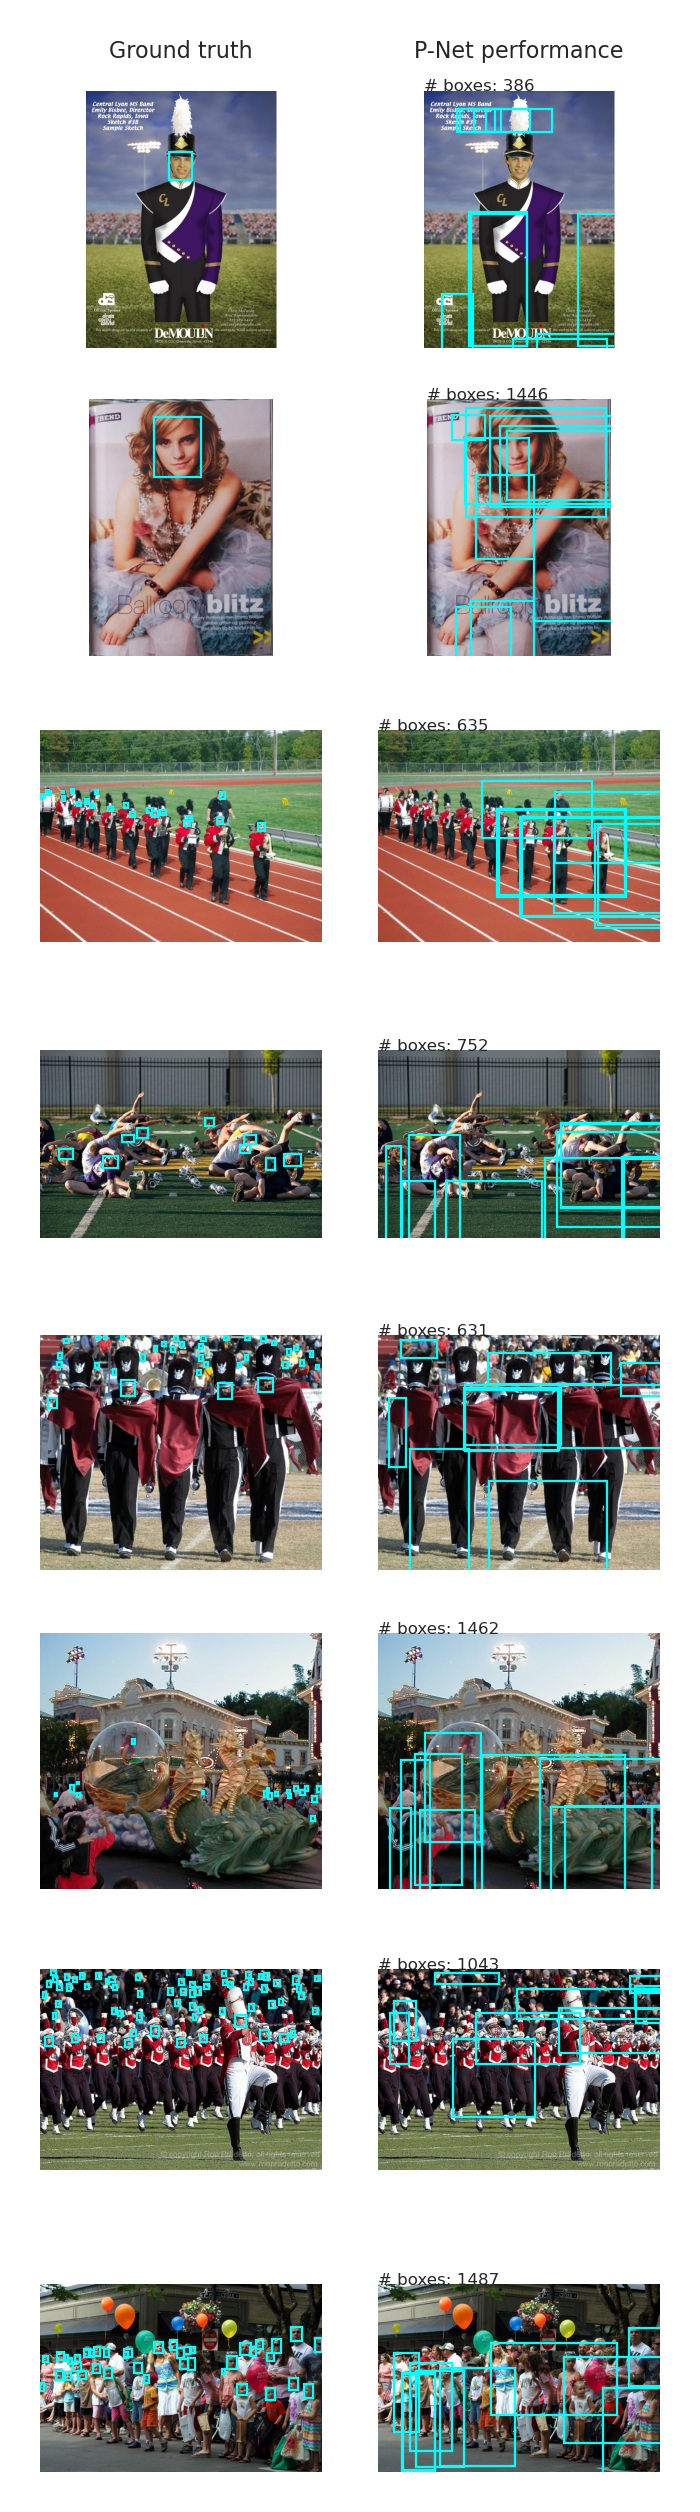

In [19]:
data_for_demo = get_widerdata('train', 8, Random=False)
num_demo = len(data_for_demo)

fig, ax = plt.subplots(num_demo,2,dpi = 400, figsize=(2,num_demo))

for i in range(num_demo):
    img_pth, gts = data_for_demo[i]
    img = Image.open(img_pth)
    bounding_boxes = pnet_boxes(img, model, min_face_size=MIN_FACE_SIZE, thresholds=THRESHOLDS, nms_thresholds=NMS_THRESHOLDS)
    
    ax[i,0].imshow(img)
    for b in gts:
        ax[i,0].add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor='cyan',linewidth=0.4))
    
    ax[i,1].imshow(img)
    ax[i,1].text(0, 0, '# boxes: '+str(len(bounding_boxes)),fontsize=3)
    # since there are too many boxes, only ten are drawn
    for b in bounding_boxes[:10]:
        ax[i,1].add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3], fill=False, edgecolor='cyan',linewidth=0.4))   

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("Ground truth",fontsize=4)
ax[0][1].set_title("P-Net performance",fontsize=4)
fig.show()
fig.savefig(name+'_demo.png')